In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [104]:
!pip install pyarrow

In [123]:
df.dtypes

VendorID                          int32
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

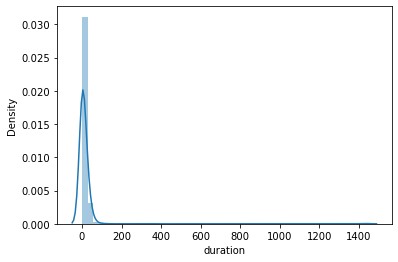

In [52]:
sns.distplot(df.duration)

In [116]:
def read_dataframe(filename): 
    
    df = pd.read_parquet(filename)
    pd.to_datetime(df.lpep_pickup_datetime)
    pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [118]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')

In [150]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0,10.983333


In [120]:
len(df_train), len(df_val)

(54373, 51497)

In [155]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)  # fit on training data

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)  # just transform val using the same fitted vectorizer

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse(y_val, y_pred, squared=False)

7.273699187127967

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.legend(*args, **kwargs)>

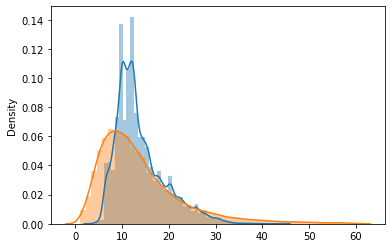

In [100]:
sns.distplot(y_pred, label='Predicted')
sns.distplot(y_train, label='Actual')
plt.legend

In [157]:
import numpy as np

print(np.isnan(X_train.data).sum(), np.isnan(X_val.data).sum())
print(np.isnan(y_train).sum(), np.isnan(y_val).sum())

0 0
0 0
